# Interactive 2D Arm - Inverse Kinematics

In [62]:
import numpy as np
import math
import matplotlib.pyplot as plt
from RobotArm import *
import time

%matplotlib notebook

class ArmPlotter:
    def __init__(self):
        # Instantiate robot arm class.
        self.Arm = RobotArm2D()

        # Add desired number of joints/links to robot arm object.
        self.Arm.add_revolute_link(length=3, thetaInit=math.radians(10))
        self.Arm.add_revolute_link(length=3, thetaInit=math.radians(15))
        self.Arm.add_revolute_link(length=3, thetaInit=math.radians(20))

        # Initialize target and joint coordinates
        self.target = self.Arm.joints[:,[-1]]
        self.Arm.update_joint_coords()

        # Plot arm and reach space
        self.initialize_plot()
        self.define_reach_space()
        
        # mode=1 (interactive) - mode = 0 (TODO)
        self.mode = 1
          
    def initialize_plot(self):
        # Initialize plot and line objects for target, end effector, and arm.
        self.fig, self.ax = plt.subplots(figsize=(5,5))
        self.fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
        self.targetPt, = self.ax.plot([], [], marker='o', c='r')
        self.endEff, = self.ax.plot([], [], marker='o', markerfacecolor='w', c='g', lw=2)
        self.armLine, = self.ax.plot([], [], marker='o', c='g', lw=2)

        self.fig.canvas.draw()
            
    def define_reach_space(self):
        # Determine maximum reach of arm.
        self.reach = sum(self.Arm.lengths)

        # Set axis limits based on reach from root joint.
        self.ax.set_xlim(self.Arm.xRoot - 1.2 * self.reach, self.Arm.xRoot + 1.2 * self.reach)
        self.ax.set_ylim(self.Arm.yRoot - 1.2 * self.reach, self.Arm.yRoot + 1.2 * self.reach)

        # Add dashed circle to plot indicating reach.
        circle = plt.Circle((self.Arm.xRoot, self.Arm.yRoot), self.reach, ls='dashed', fill=False)
        self.ax.add_artist(circle)
    
    def update_plot(self):
        self.armLine.set_data(self.Arm.joints[0,:-1], self.Arm.joints[1,:-1])
        self.endEff.set_data(self.Arm.joints[0,-2::], self.Arm.joints[1,-2::])
        self.targetPt.set_data(self.target[0], self.target[1])
        
        self.ax.add_artist(self.endEff)
        self.ax.add_artist(self.armLine)
        self.ax.add_artist(self.targetPt)
    
    def inverse_kinematics(self):
        # Set distance to move end-effector toward target per iteration.
        distPerUpdate = 0.02 * self.reach

        if np.linalg.norm(self.target - self.Arm.joints[:,[-1]]) > 0.02 * self.reach:
            targetVector = (self.target - self.Arm.joints[:,[-1]])[:3]
            targetUnitVector = targetVector / np.linalg.norm(targetVector)
            deltaR = distPerUpdate * targetUnitVector
            J = self.Arm.get_jacobian()
            JInv = np.linalg.pinv(J)
            deltaTheta = JInv.dot(deltaR)
            self.Arm.update_theta(deltaTheta)
            self.Arm.update_joint_coords()
            self.update_plot()
        
    def on_click(self, event):
        xClick = event.xdata
        yClick = event.ydata

        if (event.button == 1 and isinstance(xClick, float) and isinstance(yClick, float)):
            self.targetPt.set_data(xClick, yClick)
            self.target = np.array([[xClick, yClick, 0, 1]]).T      
        
    def interactive_plot(self):
        # Initialize periodic inverse kinematics update 
        self.timer = self.fig.canvas.new_timer(interval=10)
        self.timer.add_callback(self.inverse_kinematics)
        self.timer.start()

        # Define click event - Update target (red dot)
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.on_click)

<IPython.core.display.Javascript object>


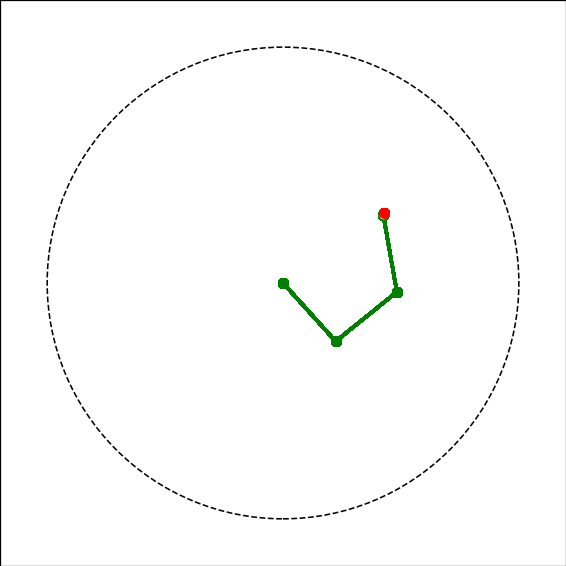

In [63]:
plotter = ArmPlotter()
plotter.interactive_plot()